<a href="https://colab.research.google.com/github/Yue-Yao/EIS/blob/main/Assignments/06-Transpose%20Convolution%20vs%20Unpooling/Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course**: Deep Learning

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/) 

[Abdulbaki Kocabasa]() \([a.kocabasa@tu-bs.de](@tu-bs.de)) and [Yao Yue]() (yue.yao@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  


# Assignment 6

---

Compare Transpose Convolution and Unpooling

link for the drive content 

https://drive.google.com/drive/folders/1kqARtL7kyuTN2udaFKIJH5joJvpR6Q7u?usp=sharing

## Mount Google Drive to Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/2022-Group04/Assignments/06-Semantic_Segmentation/Segmentation

/content/drive/My Drive/2022-Group04/Assignments/06-Semantic_Segmentation/Segmentation


# Import packages

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.metrics import OneHotMeanIoU, OneHotIoU
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
# Operation with arrays
import numpy as np
# Paths and files
from os.path import join,basename,splitext
import os
from glob import glob
from natsort import natsorted
# Reading images
import tifffile
from PIL import Image
# Others
import random

## Dataset

We will work with the ISPRS [2D Semantic Labeling benchmark - Vaihingen](https://www.isprs.org/education/benchmarks/UrbanSemLab/2d-sem-label-vaihingen.aspx).

The dataset contains 33 patches (of different sizes), each consisting of a true orthophoto (TOP), extracted from a larger TOP mosaic, and a Digital Surface Model (DSM).

<center>
<img width=500 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/overview_tiles.jpg?width=398.4830805134189&height=500" img>
</center>

Labelled ground truth is provided for all areas. An example of a patch from the dataset, where a) true orthophoto, b) DSM, and c) ground truth.

<center>
<img width=600 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/examples_top_dsm_gts.png?width=500&height=196.7930029154519" img>
</center>


### Loading the data

To create the train, validation and test sets, we will follow the benchmark guidelines:

<center>
<img width=600 src="https://www.isprs.org/education/benchmarks/UrbanSemLab/img/table_label_contest_image_overview.png?width=500&height=397.5490196078431" img>
</center>

So, the areas for training and testing are the following:

|  Set  |   Areas   |
|-------|-----------|
| Train | 1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37 |
| Test  | 2,4,6,8,10,12,14,16,20,22,24,27,29,31,33,35,38 |

The folder structure is the following:

- _dsm_: Digital Surface Models with information about the height of each geographical area.
- _gts_: Ground Truths or References with information about the semantic class of each pixel.
- _top_: True Orthophoto with a False RGB Color composition with near infrared, red and green bands.

In [12]:
# install tree package for better visualization of folder structure
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (198 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155653 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [13]:
!tree -d

.
└── ISPRS_semantic_labeling_Vaihingen
    ├── dsm
    ├── gts
    └── top

4 directories


Reading all images from the _top_, _dsm_ and _gts_ folders

In [14]:
# Path to the dataset folder in Google Drive
root_path = "ISPRS_semantic_labeling_Vaihingen"
path_top = join(root_path,"top")
path_dsm = join(root_path,"dsm")
path_gts = join(root_path,"gts")

# List with all TIF images in each folder
list_top = glob(join(path_top,"*.tif"))
list_top = natsorted(list_top, key=lambda y: y.lower())

list_dsm = glob(join(path_dsm,"*.tif"))
list_dsm = natsorted(list_dsm, key=lambda y: y.lower())

list_gts = glob(join(path_gts,"*.tif"))
list_gts = natsorted(list_gts, key=lambda y: y.lower())

### Train, Validation and Test
Let's create the train, validation and test sets

In [15]:
# Images IDs for train and test
train_ids = [1,3,5,7,11,13,15,17,21,23,26,28,30,32,34,37]
test_ids = [2,4,6,8,10,12,14,16,20,22,24,27,29,31,33,35,38]

list_top_train, list_top_val, list_top_test = ([] for i in range(3))
list_dsm_train, list_dsm_val, list_dsm_test = ([] for i in range(3))
list_gts_train, list_gts_val, list_gts_test = ([] for i in range(3))

In [16]:
for top,dsm,gts in zip(list_top,list_dsm,list_gts):
  # Get the area ID from the filename
  area_id = int(splitext(basename(top))[0].split("area")[-1])
  # Train set
  if area_id in train_ids:    
    list_top_train.append(top)
    list_dsm_train.append(dsm)
    list_gts_train.append(gts)
  # Test set
  elif area_id in test_ids:    
    list_top_test.append(top)
    list_dsm_test.append(dsm)
    list_gts_test.append(gts)

# shuffle train lists
temp = list(zip(list_top_train,list_dsm_train,list_gts_train))
random.seed(10)
random.shuffle(temp)
list_top_train,list_dsm_train,list_gts_train = zip(*temp)

# take 25% as validation set
p_val = 0.25
n_val = int(p_val*len(list_top_train))

list_top_val = list_top_train[:n_val]
list_top_train = list_top_train[n_val:]

list_dsm_val = list_dsm_train[:n_val]
list_dsm_train = list_dsm_train[n_val:]

list_gts_val = list_gts_train[:n_val]
list_gts_train = list_gts_train[n_val:]

### Dataset information

In [17]:
def print_info(list_top,list_dsm,list_gts):
  for top,dsm,gts in zip(list_top,list_dsm,list_gts):
    gt_temp = tifffile.imread(gts)
    n_classes = len(np.unique(gt_temp.reshape(gt_temp.shape[0]*gt_temp.shape[1],-1),axis=0))
    print("TOP:{} , DSM:{} , GT:{} , N:{}".format(basename(top),
                                  basename(dsm),
                                  basename(gts),
                                  n_classes))

Let's see the number of classes in each image. 

**It is very important that all sets have samples of all classes.**

In [18]:
# Train
print("Train:")
print_info(list_top_train,list_dsm_train,list_gts_train)

# Validation
print("\nValidation:")
print_info(list_top_val,list_dsm_val,list_gts_val)

# Test
print("\nTest:")
print_info(list_top_test,list_dsm_test,list_gts_test)

Train:
TOP:top_mosaic_09cm_area28.tif , DSM:dsm_09cm_matching_area28.tif , GT:top_mosaic_09cm_area28.tif , N:6
TOP:top_mosaic_09cm_area37.tif , DSM:dsm_09cm_matching_area37.tif , GT:top_mosaic_09cm_area37.tif , N:5
TOP:top_mosaic_09cm_area13.tif , DSM:dsm_09cm_matching_area13.tif , GT:top_mosaic_09cm_area13.tif , N:5
TOP:top_mosaic_09cm_area11.tif , DSM:dsm_09cm_matching_area11.tif , GT:top_mosaic_09cm_area11.tif , N:5
TOP:top_mosaic_09cm_area30.tif , DSM:dsm_09cm_matching_area30.tif , GT:top_mosaic_09cm_area30.tif , N:5
TOP:top_mosaic_09cm_area32.tif , DSM:dsm_09cm_matching_area32.tif , GT:top_mosaic_09cm_area32.tif , N:6
TOP:top_mosaic_09cm_area7.tif , DSM:dsm_09cm_matching_area7.tif , GT:top_mosaic_09cm_area7.tif , N:5
TOP:top_mosaic_09cm_area1.tif , DSM:dsm_09cm_matching_area1.tif , GT:top_mosaic_09cm_area1.tif , N:6
TOP:top_mosaic_09cm_area23.tif , DSM:dsm_09cm_matching_area23.tif , GT:top_mosaic_09cm_area23.tif , N:6
TOP:top_mosaic_09cm_area17.tif , DSM:dsm_09cm_matching_area17.t

### Visualization of dataset samples

Image: ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area7.tif


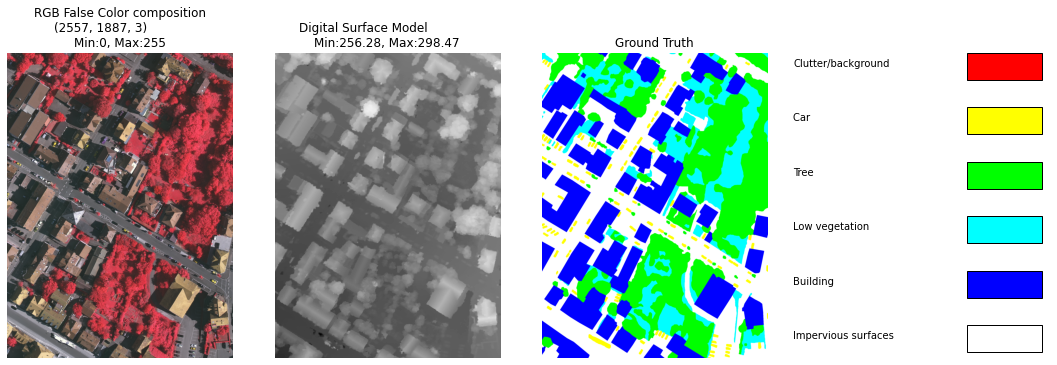

In [22]:
#@title Samples Visualization { run: "auto"}
#@markdown Select a sample
id_sample = 6 #@param {type:"slider", min:0, max:32, step:1}
img_top = tifffile.imread(list_top[id_sample])
img_dsm = tifffile.imread(list_dsm[id_sample])

print("Image: {}".format(list_top[id_sample]))

plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
plt.imshow(img_top)
plt.title("RGB False Color composition\n{}\
          \nMin:{}, Max:{}".format(img_top.shape,
                                     img_top.min(),
                                     img_top.max()))
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(img_dsm, cmap="gray")
plt.title("Digital Surface Model\
            \nMin:{:.2f}, Max:{:.2f}".format(img_dsm.min(),
                                             img_dsm.max()))
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(tifffile.imread(list_gts[id_sample]))
plt.title("Ground Truth")
plt.axis("off")

g = plt.subplot(1,4,4)
g.axes.set_xlim(0,3.4)
g.axes.set_ylim(-0.01,0.55)

g.text(0, 0.025, "Impervious surfaces")
g.text(0, 0.125, "Building ")
g.text(0, 0.225, "Low vegetation")
g.text(0, 0.325, "Tree ")
g.text(0, 0.425, "Car ")
g.text(0, 0.525, "Clutter/background")

x_rec = 2.3
g.add_patch(patches.Rectangle((x_rec,0.0), 1, 0.05, facecolor="#FFFFFF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.1), 1, 0.05, facecolor="#0000FF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.2), 1, 0.05, facecolor="#00FFFF", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.3), 1, 0.05, facecolor="#00FF00", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.4), 1, 0.05, facecolor="#FFFF00", edgecolor="black"))
g.add_patch(patches.Rectangle((x_rec,0.5), 1, 0.05, facecolor="#FF0000", edgecolor="black"))
g.axis("off")

plt.tight_layout()
plt.show()

### Classes
Dictionary to represent each color and its corresponding class.

In [19]:
color2index = {(255,255,255) : 0,
               (0  ,0  ,255) : 1,
               (0  ,255,255) : 2,
               (0  ,255,0  ) : 3,
               (255,255,0  ) : 4,
               (255,0  ,0  ) : 5
               }
n_classes = len(color2index)

## Data Generator

Requirements of the model:

- **Input:** Image $[height×width×bands]$
- **Output:** Image $[height×width×classes]$

As the images are too big, we will extract patches with a size $[p×p]$ and step (stride) $s$.

<center>
<img src="https://drive.google.com/uc?export=view&id=1UYrpG-sD_UGCRR7Ras73THF-sbqQoGTu" width=100 img>
</center>


Data Generator parameters:
- _batch_size_: number of samples per batch
- _patch_size_: size of the patch extracted from the image
- _step_size_: step to extract patches from the image
- _list_top_: list with paths of RGB images
- _list_dsm_: list with paths of DSM images
- _list_gts_: list with paths of GT images
- _n_classes_: number of classes
- _colormap_gt_: dictionary with the colormap to convert RGB image $[H×W×3]$ to label image $[H×W×1]$

**Recommendation:** Use [Pillow](https://pillow.readthedocs.io/en/stable/) to reduce processing time in reading and cropping the image, because it just loads the part of the image specified by the method [crop](https://pillow.readthedocs.io/en/stable/reference/ImageOps.html?highlight=crop#PIL.ImageOps.crop) when it is converted to a numpy array (_np.asarray_).

```python
# Just reading the header of the image with its information
data = Image.open(path)
# Cropping the area of the image
data = data.crop((x, y, x+patch_size, y+patch_size)
# Loads only the cropped area of the image
data = np.asarray(data)
```



In [20]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self,
               batch_size,
               patch_size,
               step_size,
               list_top,                
               list_gts,
               n_classes,
               colormap_gt=None,
               augmentation=None,
               preprocessing=None,               
               shuffle=True):
    self.batch_size = batch_size
    self.patch_size = patch_size
    self.step_size = step_size
    self.list_top = list_top    
    self.list_gts = list_gts
    self.n_classes = n_classes
    self.colormap_gt = colormap_gt
    self.augmentation = augmentation
    self.preprocessing = preprocessing        
    self.shuffle= shuffle
    self.path_coords = self.__get_path_coords()
    self.n_patchs = len(self.path_coords)

  def __get_path_coords(self):
    path_coords = []    
    for path_image, path_label in zip(self.list_top,self.list_gts):       
      width, height = Image.open(path_label).size      
      for y in range(0, height, self.step_size):
        for x in range(0, width, self.step_size):
          if (x + self.patch_size) > width:
            x = width - self.patch_size
          if (y + self.patch_size) > height:
            y = height - self.patch_size
          
          path_coords.append((path_image, path_label, (x,y)))          
    return path_coords
        
  def on_epoch_end(self):
    if self.shuffle:
      random.shuffle(self.path_coords)

  def __len__(self):
    return np.ceil(self.n_patchs/self.batch_size).astype("int")

  def __get_patch_image(self, path_image, x, y):
    # Reading the RGB image
    data_image = Image.open(path_image)
    data_image = data_image.crop((x, y, 
                                  x + self.patch_size, y + self.patch_size))
    data_image = np.asarray(data_image).astype("float32")
    
    return data_image/255.0

  def __get_patch_mask(self, path, x, y):
    # Reading the mask
    data_mask = Image.open(path)
    data_mask = data_mask.crop((x, y, 
                                x + self.patch_size, y + self.patch_size))
    data_mask = np.asarray(data_mask)
    # Convert RGB image [H x W x 3] to label image [H x W x 1]
    data_mask_idx = np.zeros((data_mask.shape[0], 
                              data_mask.shape[1]), dtype=np.uint8)
    for key in self.colormap_gt:
      class_id = self.colormap_gt[key]
      key = np.array(key)
      # Assign an index to each color based on the colormap
      # (255,255,255) : 0
      # (0  ,0  ,255) : 1,...
      data_mask_idx[(data_mask[:,:,0] == key[0]) & 
                    (data_mask[:,:,1] == key[1]) & 
                    (data_mask[:,:,2] == key[2])] = class_id
    return data_mask_idx

  def __getitem__(self, idx):
    i = idx * self.batch_size
    
    current_batch_size = self.batch_size
    if (idx+1) == self.__len__():
      current_batch_size = len(self.path_coords[i:])

    # Batch of coordinates
    batch_path_coords = self.path_coords[i : i + current_batch_size]

    x = np.zeros((current_batch_size, 
                  self.patch_size, 
                  self.patch_size, 
                  3),
                  dtype=np.float32)

    y = np.zeros((current_batch_size,
                  self.patch_size, 
                  self.patch_size,
                  self.n_classes),
                  dtype=np.float32)

    for j, (path_image, path_label, (x_pos, y_pos)) in enumerate(batch_path_coords):
      # Get an individual image and its corresponding label
      x_sample = self.__get_patch_image(path_image, x_pos, y_pos)
      y_sample = self.__get_patch_mask(path_label, x_pos, y_pos)        
      
      # If there are augmentation transformations, apply them
      if self.augmentation is not None:
        augmented = self.augmentation()(image=x_sample, mask=y_sample)
        x_sample = augmented["image"]
        y_sample = augmented["mask"]
      # If there is a preprocessing function, apply it
      if self.preprocessing is not None:
        preprocessed = self.preprocessing(image=x_sample, mask=y_sample)
        x_sample = preprocessed['image']
        y_sample = preprocessed['mask']
      # Convert labels to one hot encoding
      y_sample = to_categorical(y_sample, self.n_classes)

      x[j,...] = x_sample
      y[j,...] = y_sample
    return x, y

Create a temporal generator just to verify the output of our class DataGenerator and visualize a batch.

(4, 256, 256, 3) (4, 256, 256, 6)


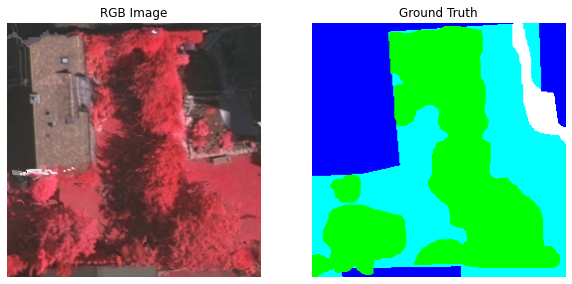

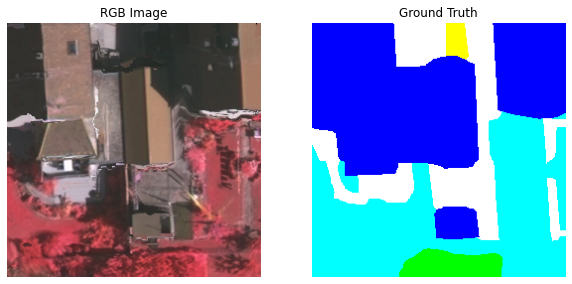

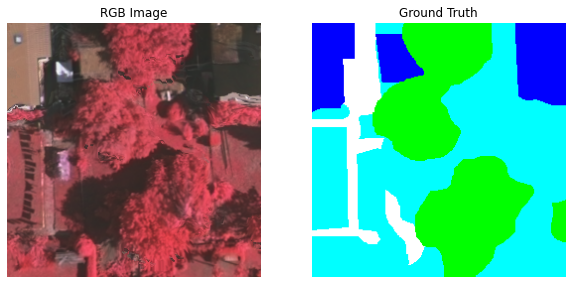

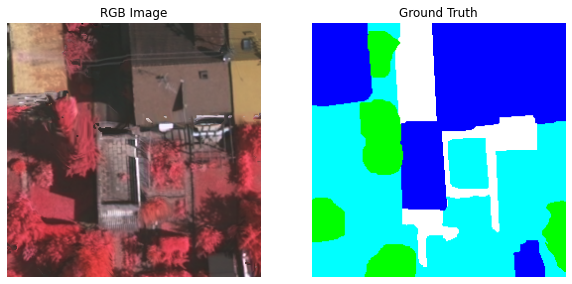

In [21]:
# Temporal generator
temp_generator = DataGenerator(batch_size=4,
                         patch_size=256,
                         step_size=256,
                         list_top=list_top_train, 
                         list_gts=list_gts_train,
                         n_classes=n_classes,
                         colormap_gt=color2index
                         )
# Iterate over all batches
for x,y in temp_generator:
  # Check the shape of the output of the generator
  print(x.shape, y.shape)
  for x_i,y_i in zip(x,y):
    # For visualization: [0,1] => [0,255]
    x_i = x_i*255
    # Apply argmax to convert from one hot to integers
    y_i = np.argmax(y_i, axis=-1)
    # Convert each class to a color given a colormap
    y_i_rgb = np.zeros((y_i.shape[0], y_i.shape[1], 3), dtype=np.uint8)
    for key,value in color2index.items():
      y_i_rgb[y_i==value] = key      
    # Visualization of RGB image and its ground truth or reference
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(x_i.astype("uint8"))
    plt.title("RGB Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(y_i_rgb, cmap="jet")
    plt.title("Ground Truth")
    plt.axis("off")
    plt.show()
  break

### DataGenerator for train and validation

Let's create the generators for training and validation:
- $batch\_size=8$
- $patch\_size=256$
- $step\_size=256$

In [22]:
batch_size = 8
patch_size = 256
step_size = 256

data_gen_train = DataGenerator(batch_size=batch_size,
                               patch_size=patch_size,
                               step_size=step_size,
                               list_top=list_top_train, 
                               list_gts=list_gts_train,
                               n_classes=n_classes,
                               colormap_gt=color2index
                               )

data_gen_val = DataGenerator(batch_size=batch_size,
                             patch_size=patch_size,
                             step_size=step_size,
                             list_top=list_top_val, 
                             list_gts=list_gts_val,
                             n_classes=n_classes,
                             colormap_gt=color2index
                             )                             

Number of batches in each set:

In [23]:
print("Train: {}, Validation: {}".format(len(data_gen_train), len(data_gen_val)))

Train: 128, Validation: 38


## Semantic Segmentation models
We will use the U-Net model for multiclass semantic segmentation.

<center>
<img width=700 src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" img>
</center>

Code based on [U-Net image segmentation in Keras](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)



Functions with block to build a U-Net:
- _conv_block_: convolutional block with only multiple convolutions.
- _downsampling_: downsampling block with a series of convolutions, a max pooling and dropout layers.
- _upsampling_: upsampling block with a transpose convolution, concatenate a feature map, dropout and a series of convolutions.

the combination of upsampling and the convolution, if applied well, equals the effect of the transposed convolution. This hence allows us to reconstruct the image into its original size, presumably without losing a lot of details (which would have happened with upsampling alone, if such reconstruction would have been possible at all).

In [24]:
def conv_block(x, n_filters, times=2):
  for i in range(times):
    x = Conv2D(filters=n_filters, 
              kernel_size=3, 
              strides=1, 
              padding="same", 
              activation="relu", 
              kernel_initializer="he_normal")(x)
  return x

def downsampling(x, n_filters, times=2):
  feat = conv_block(x, n_filters, times=times)  
  pool = MaxPooling2D(pool_size=2)(feat)
  pool = Dropout(rate=0.3)(pool)
  return feat,pool

def upsampling(input, filters, layer_concat=None):
  x = Conv2DTranspose(filters=filters, 
                      kernel_size=3, 
                      strides=2, 
                      padding="same")(input)
  if layer_concat is not None:
    x = concatenate([x, layer_concat])
  x = Dropout(rate=0.3)(x)  
  x = conv_block(x, filters, times=2)
  return x

    
def upsampling_nearest(input, filters, layer_concat=None):
  x = UpSampling2D(size=(2, 2),
              interpolation="nearest")(input)
  
  if layer_concat is not None:
    x = concatenate([x, layer_concat])
  x = Dropout(rate=0.3)(x)  
  x = conv_block(x, filters, times=2)
  return x    

def upsampling_bilinear(input, filters, layer_concat=None):
  x = UpSampling2D(size=(2, 2),
              interpolation="bilinear")(input)
  
  if layer_concat is not None:
    x = concatenate([x, layer_concat])
  x = Dropout(rate=0.3)(x)  
  x = conv_block(x, filters, times=2)
  return x

    

Building the U-Net model.

_Notice that the original model has a bottleneck area with **1024** features, we are only using **512** for this example._

Building the U-Net model with "Transpose Conv Layers"

In [6]:
def get_unet_transpose_conv(img_size, n_classes):
  # Input
  input = Input(shape=(img_size,img_size,3))
  # Downsampling
  f1,p1 = downsampling(input, 64, times=2)
  f2,p2 = downsampling(p1, 128, times=2)
  f3,p3 = downsampling(p2, 256, times=2)
  # Bottleneck
  blottleneck = conv_block(p3, 512, times=2)
  #Upsampling  
  u7 = upsampling(blottleneck, 256, layer_concat=f3)
  u8 = upsampling(u7, 128, layer_concat=f2)
  u9 = upsampling(u8, 64, layer_concat=f1)
  # Output
  output = Conv2D(filters=n_classes, 
                  kernel_size=1, 
                  padding="same", 
                  activation="softmax")(u9)
  model = Model(inputs=input, outputs=output, name="UNet")

  return model

Building the U-Net model with "Unpooling with Nearest Neighbor"

In [7]:
def get_unet_nearest_neighbor(img_size, n_classes):
  # Input
  input = Input(shape=(img_size,img_size,3))
  # Downsampling
  f1,p1 = downsampling(input, 64, times=2)
  f2,p2 = downsampling(p1, 128, times=2)
  f3,p3 = downsampling(p2, 256, times=2)
  # Bottleneck
  blottleneck = conv_block(p3, 512, times=2)
  #Upsampling  
  u7 = upsampling_nearest(blottleneck, 256, layer_concat=f3)
  u8 = upsampling_nearest(u7, 128, layer_concat=f2)
  u9 = upsampling_nearest(u8, 64, layer_concat=f1)
  # Output
  output = Conv2D(filters=n_classes, 
                  kernel_size=1, 
                  padding="same", 
                  activation="softmax")(u9)
  model = Model(inputs=input, outputs=output, name="UNet")

  return model

Building the U-Net model with "Unpooling with Bed of Nails"

In [8]:
def get_unet_bilinear(img_size, n_classes):
  # Input
  input = Input(shape=(img_size,img_size,3))
  # Downsampling
  f1,p1 = downsampling(input, 64, times=2)
  f2,p2 = downsampling(p1, 128, times=2)
  f3,p3 = downsampling(p2, 256, times=2)
  # Bottleneck
  blottleneck = conv_block(p3, 512, times=2)
  #Upsampling  
  u7 = upsampling_bilinear(blottleneck, 256, layer_concat=f3)
  u8 = upsampling_bilinear(u7, 128, layer_concat=f2)
  u9 = upsampling_bilinear(u8, 64, layer_concat=f1)
  # Output
  output = Conv2D(filters=n_classes, 
                  kernel_size=1, 
                  padding="same", 
                  activation="softmax")(u9)
  model = Model(inputs=input, outputs=output, name="UNet")

  return model

Building the U-Net models

In [25]:
model_unet_transpose_conv = get_unet_transpose_conv(img_size=patch_size, 
                    n_classes=n_classes)
model_unet_nearest_neighbor = get_unet_nearest_neighbor(img_size=patch_size, 
                    n_classes=n_classes)
model_unet_bilinear = get_unet_bilinear(img_size=patch_size, 
                    n_classes=n_classes)

### Visualization of U-Net

In [34]:
model_unet_transpose_conv.summary()
model_unet_nearest_neighbor.summary()
model_unet_bilinear.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                              

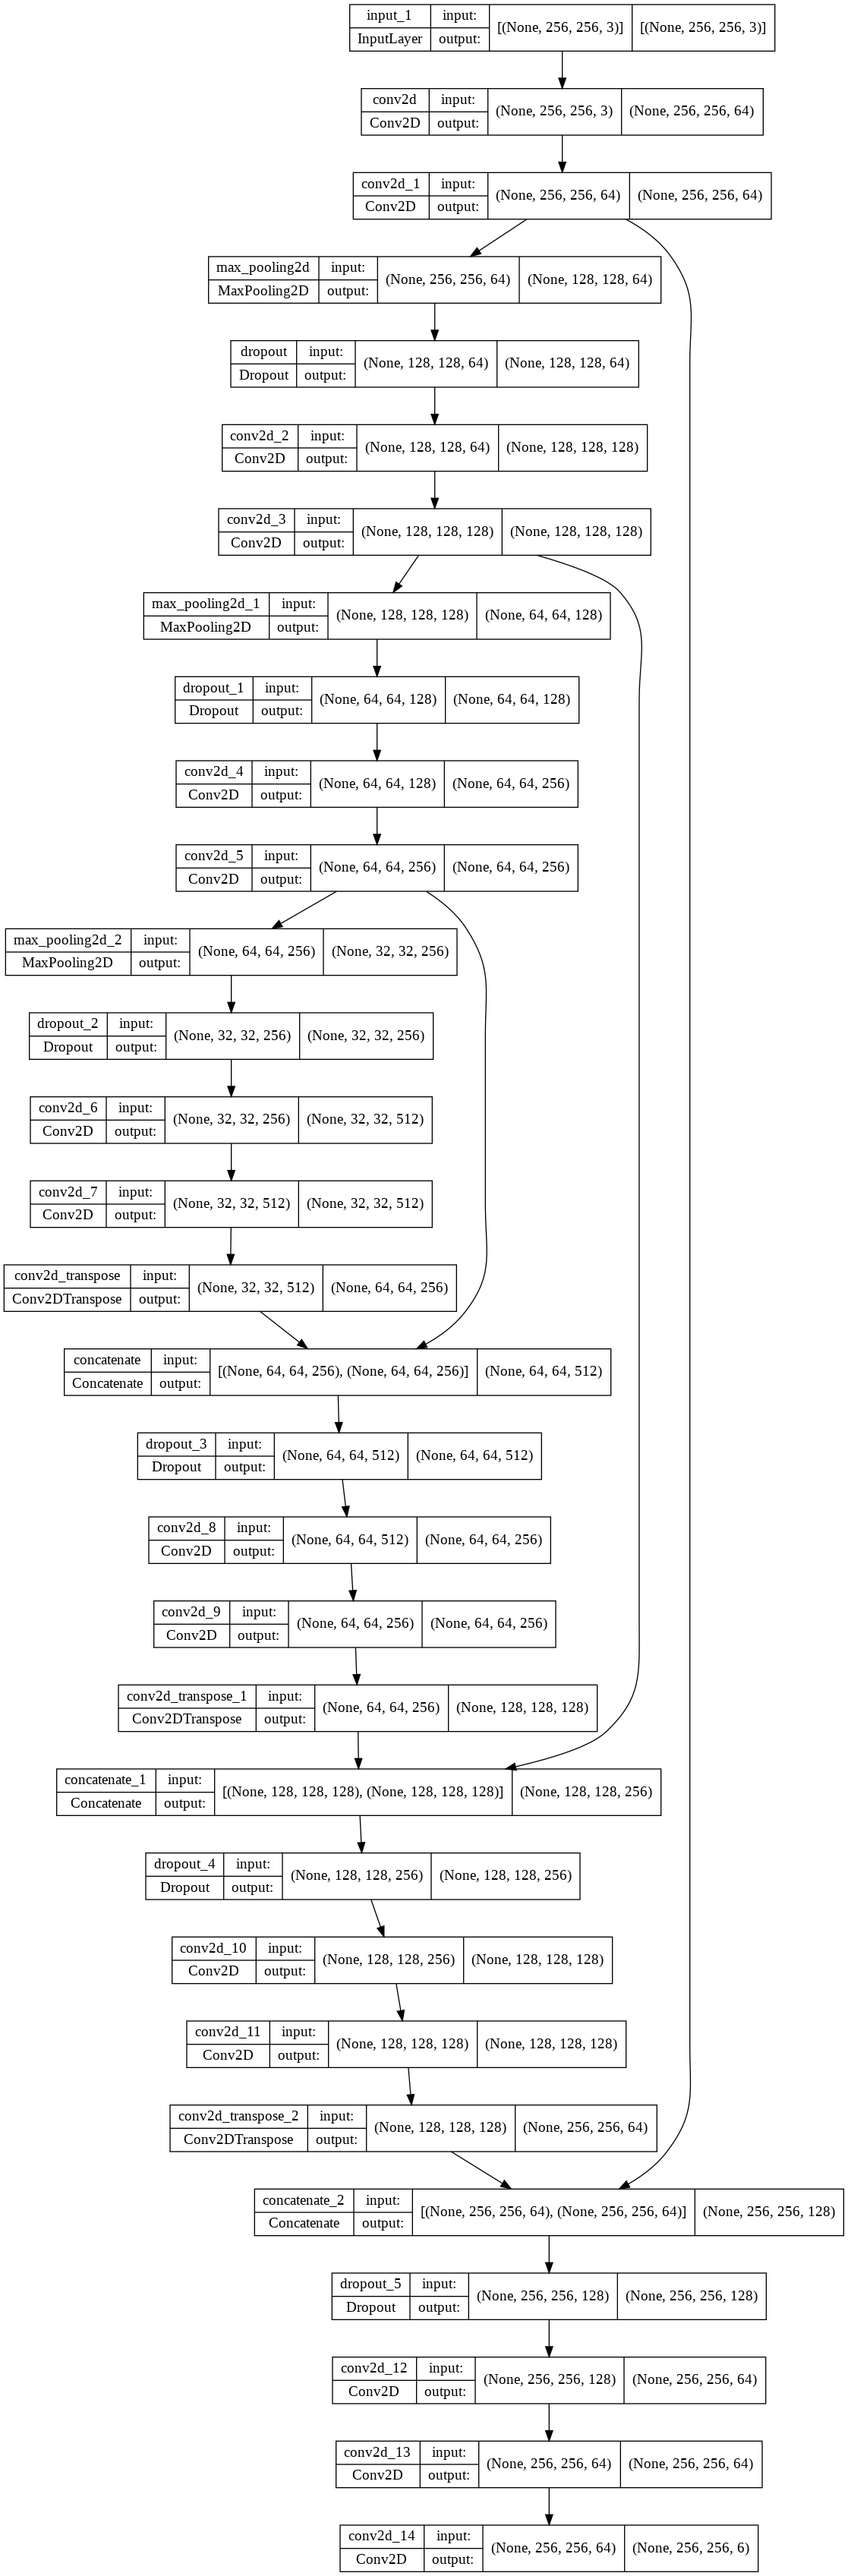

In [35]:
plot_model(model_unet_transpose_conv, to_file="model_unet_2.png", show_shapes=True)

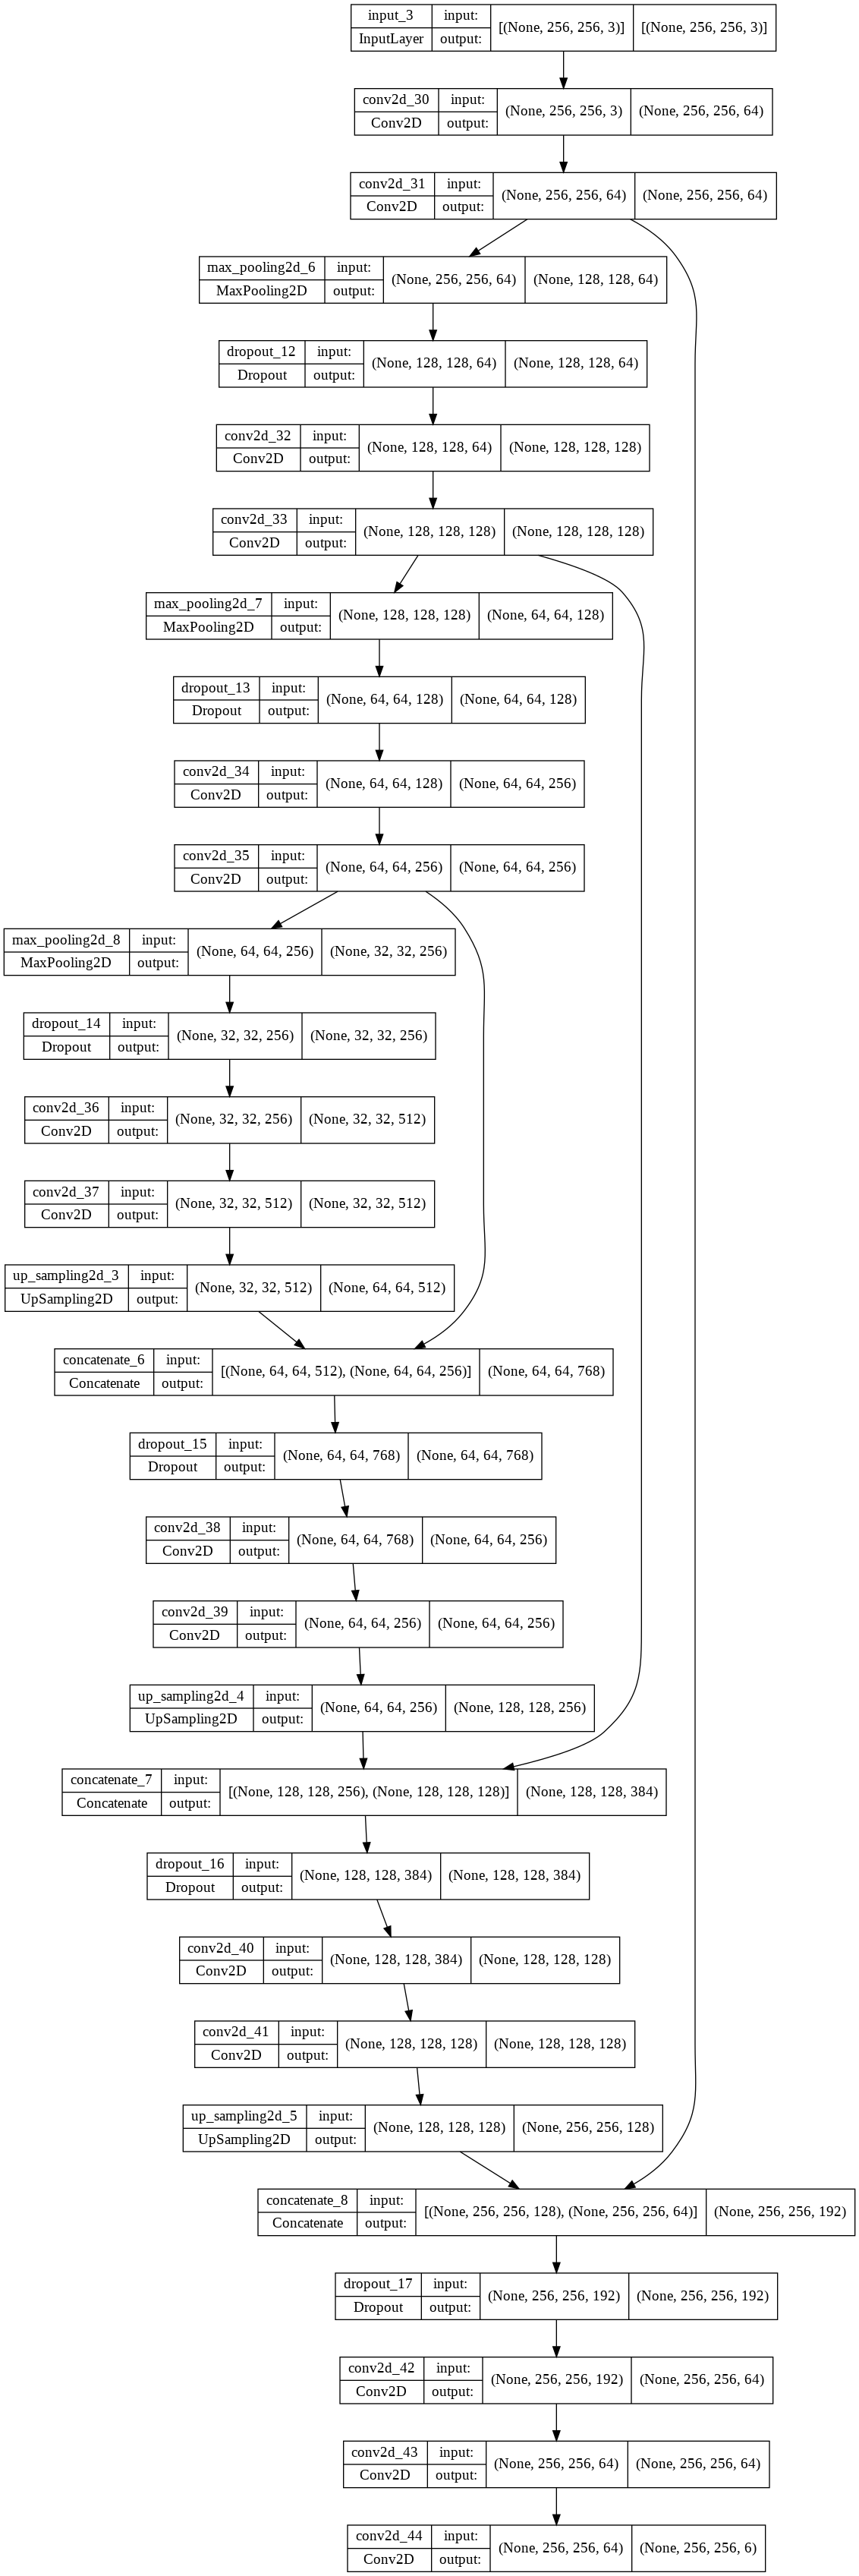

In [36]:
plot_model(model_unet_bilinear, to_file="model_unet_3.png", show_shapes=True)

### Training configuration

We will use _Intersection over Union (IoU)_ as metric to be monitored during training.

As the labels are in _one hot_ encoding, we can use the _one hot_ version of _mean IoU_: [OneHotMeanIoU](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/OneHotMeanIoU).

Also, to assess the model, we will compute the IoU per class in the test set, so we can use: [OneHotIoU](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/OneHotIoU) per class.

In [37]:
model_unet_transpose_conv.compile(optimizer=Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", OneHotMeanIoU(num_classes=n_classes, name="iou")])

In [38]:
model_unet_nearest_neighbor.compile(optimizer=Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", OneHotMeanIoU(num_classes=n_classes, name="iou")])

In [39]:
model_unet_bilinear.compile(optimizer=Adam(),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", OneHotMeanIoU(num_classes=n_classes, name="iou")])

### Callbacks

Function to save checkpoints for each model

In [40]:
def get_ckpt(ckpt_name):
    return ModelCheckpoint(ckpt_name,
                           mode="max", 
                           save_best_only=True, 
                           monitor="val_iou", 
                           verbose=1)

Callbacks definition to be executed during training

In [41]:
# Callbacks
# Checkpoint
autosave_unet_transpose_conv = get_ckpt("segmentation_unet_transpose_conv.h5")
autosave_unet_nearest_neighbor = get_ckpt("segmentation_unet_nearest_neighbor.h5")
autosave_unet_bilinear = get_ckpt("segmentation_unet_bilinear.h5")

# Early stopping
early_stopping = EarlyStopping(patience=30, verbose=1, mode = 'auto')

cbks_unet_transpose_conv = [autosave_unet_transpose_conv, early_stopping]
cbks_unet_nearest_neighbor = [autosave_unet_nearest_neighbor, early_stopping]
cbks_unet_bilinear = [autosave_unet_bilinear, early_stopping]

In [42]:
epochs = 200

### Training

In [43]:
history_unet_transpose_conv = model_unet_transpose_conv.fit(data_gen_train,
                              epochs=epochs,                                                     
                              validation_data=data_gen_val,                                                    
                              callbacks=cbks_unet_transpose_conv,
                              workers=4, 
                              use_multiprocessing=True,
                              max_queue_size=20
                              )

Epoch 1/200
128/128 [==============================] - ETA: 0s - loss: 1.0458 - accuracy: 0.5283 - iou: 0.2385
Epoch 1: val_iou improved from -inf to 0.29088, saving model to segmentation_unet_transpose_conv.h5
128/128 [==============================] - 107s 654ms/step - loss: 1.0458 - accuracy: 0.5283 - iou: 0.2385 - val_loss: 0.9548 - val_accuracy: 0.6168 - val_iou: 0.2909
Epoch 2/200
128/128 [==============================] - ETA: 0s - loss: 0.8234 - accuracy: 0.6566 - iou: 0.3278
Epoch 2: val_iou improved from 0.29088 to 0.34853, saving model to segmentation_unet_transpose_conv.h5
128/128 [==============================] - 95s 724ms/step - loss: 0.8234 - accuracy: 0.6566 - iou: 0.3278 - val_loss: 0.8725 - val_accuracy: 0.6856 - val_iou: 0.3485
Epoch 3/200
128/128 [==============================] - ETA: 0s - loss: 0.7739 - accuracy: 0.6833 - iou: 0.3515
Epoch 3: val_iou did not improve from 0.34853
128/128 [==============================] - 94s 720ms/step - loss: 0.7739 - accuracy: 

In [44]:
history_unet_nearest_neighbor = model_unet_nearest_neighbor.fit(data_gen_train,
                              epochs=epochs,                                                     
                              validation_data=data_gen_val,                                                    
                              callbacks=cbks_unet_nearest_neighbor,
                              workers=4, 
                              use_multiprocessing=True,
                              max_queue_size=20
                              )

Epoch 1/200
128/128 [==============================] - ETA: 0s - loss: 1.1320 - accuracy: 0.5326 - iou: 0.2444
Epoch 1: val_iou improved from -inf to 0.32721, saving model to segmentation_unet_nearest_neighbor.h5
128/128 [==============================] - 103s 748ms/step - loss: 1.1320 - accuracy: 0.5326 - iou: 0.2444 - val_loss: 0.8984 - val_accuracy: 0.6531 - val_iou: 0.3272
Epoch 2/200
128/128 [==============================] - ETA: 0s - loss: 0.8507 - accuracy: 0.6409 - iou: 0.3163
Epoch 2: val_iou improved from 0.32721 to 0.36844, saving model to segmentation_unet_nearest_neighbor.h5
128/128 [==============================] - 118s 910ms/step - loss: 0.8507 - accuracy: 0.6409 - iou: 0.3163 - val_loss: 0.8151 - val_accuracy: 0.7096 - val_iou: 0.3684
Epoch 3/200
128/128 [==============================] - ETA: 0s - loss: 0.7748 - accuracy: 0.6817 - iou: 0.3476
Epoch 3: val_iou improved from 0.36844 to 0.38159, saving model to segmentation_unet_nearest_neighbor.h5
128/128 [============

In [45]:
history_unet_bilinear = model_unet_bilinear.fit(data_gen_train,
                              epochs=epochs,                                                     
                              validation_data=data_gen_val,                                                    
                              callbacks=cbks_unet_bilinear,
                              workers=4, 
                              use_multiprocessing=True,
                              max_queue_size=20
                              )

Epoch 1/200
128/128 [==============================] - ETA: 0s - loss: 1.0880 - accuracy: 0.5479 - iou: 0.2553
Epoch 1: val_iou improved from -inf to 0.33271, saving model to segmentation_unet_bilinear.h5
128/128 [==============================] - 119s 905ms/step - loss: 1.0880 - accuracy: 0.5479 - iou: 0.2553 - val_loss: 0.8760 - val_accuracy: 0.6620 - val_iou: 0.3327
Epoch 2/200
128/128 [==============================] - ETA: 0s - loss: 0.8602 - accuracy: 0.6431 - iou: 0.3184
Epoch 2: val_iou did not improve from 0.33271
128/128 [==============================] - 107s 819ms/step - loss: 0.8602 - accuracy: 0.6431 - iou: 0.3184 - val_loss: 0.9722 - val_accuracy: 0.5531 - val_iou: 0.2429
Epoch 3/200
128/128 [==============================] - ETA: 0s - loss: 0.8188 - accuracy: 0.6520 - iou: 0.3248
Epoch 3: val_iou improved from 0.33271 to 0.33555, saving model to segmentation_unet_bilinear.h5
128/128 [==============================] - 105s 801ms/step - loss: 0.8188 - accuracy: 0.6520 - i

### Load trained model

In [26]:
model_unet_transpose_conv.load_weights("segmentation_unet_transpose_conv.h5")
model_unet_nearest_neighbor.load_weights("segmentation_unet_nearest_neighbor.h5")
model_unet_bilinear.load_weights("segmentation_unet_bilinear.h5")


## Model evaluation
Let's compute the metrics and loss function values for the trained model.

In [27]:
data_gen_test = DataGenerator(batch_size=batch_size,
                              patch_size=patch_size,
                              step_size=step_size,
                              list_top=list_top_test, 
                              list_gts=list_gts_test,
                              n_classes=n_classes,
                              colormap_gt=color2index
                              )



In [48]:
print("Train:")
scores_train = model_unet_transpose_conv.evaluate(data_gen_train)

print("Validation:")
scores_val = model_unet_transpose_conv.evaluate(data_gen_val)

print("Test:")
scores_test = model_unet_transpose_conv.evaluate(data_gen_test)

Train:
128/128 [==============================] - 72s 560ms/step - loss: 0.3687 - accuracy: 0.8556 - iou: 0.6542
Validation:
38/38 [==============================] - 20s 514ms/step - loss: 0.6958 - accuracy: 0.8180 - iou: 0.5279
Test:
190/190 [==============================] - 132s 695ms/step - loss: 0.5931 - accuracy: 0.8009 - iou: 0.5186


In [49]:
print("Train:")
scores_train = model_unet_nearest_neighbor.evaluate(data_gen_train)

print("Validation:")
scores_val = model_unet_nearest_neighbor.evaluate(data_gen_val)

print("Test:")
scores_test = model_unet_nearest_neighbor.evaluate(data_gen_test)

Train:
128/128 [==============================] - 72s 557ms/step - loss: 0.2246 - accuracy: 0.9142 - iou: 0.7508
Validation:
38/38 [==============================] - 20s 512ms/step - loss: 0.6954 - accuracy: 0.8288 - iou: 0.5494
Test:
190/190 [==============================] - 115s 605ms/step - loss: 0.5867 - accuracy: 0.8259 - iou: 0.5638


In [50]:
print("Train:")
scores_train = model_unet_bilinear.evaluate(data_gen_train)

print("Validation:")
scores_val = model_unet_bilinear.evaluate(data_gen_val)

print("Test:")
scores_test = model_unet_bilinear.evaluate(data_gen_test)

Train:
128/128 [==============================] - 71s 553ms/step - loss: 0.1413 - accuracy: 0.9457 - iou: 0.8417
Validation:
38/38 [==============================] - 20s 513ms/step - loss: 0.7273 - accuracy: 0.8257 - iou: 0.5495
Test:
190/190 [==============================] - 115s 604ms/step - loss: 0.7609 - accuracy: 0.8136 - iou: 0.5589


## Visualization of the predictions

buraya update gelecek

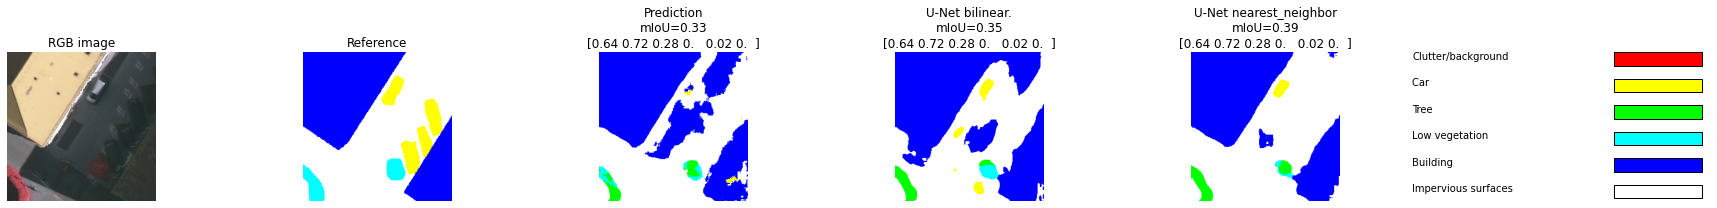

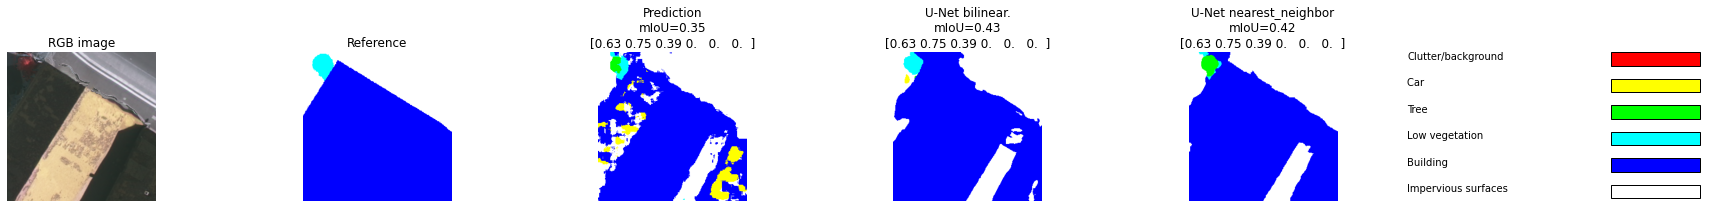

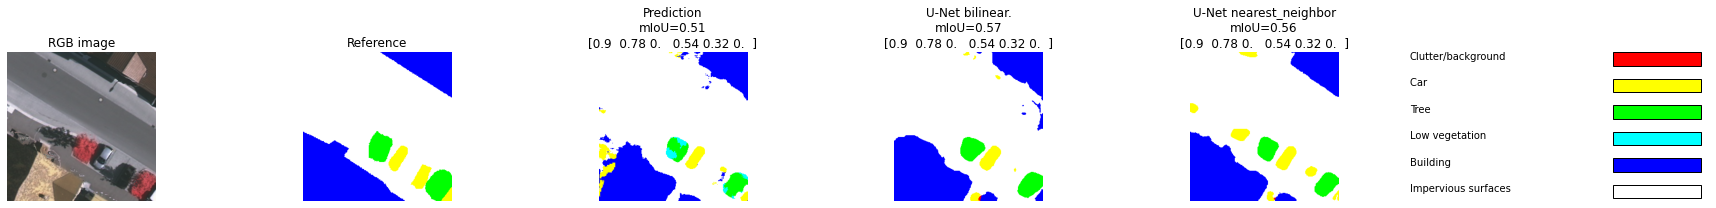

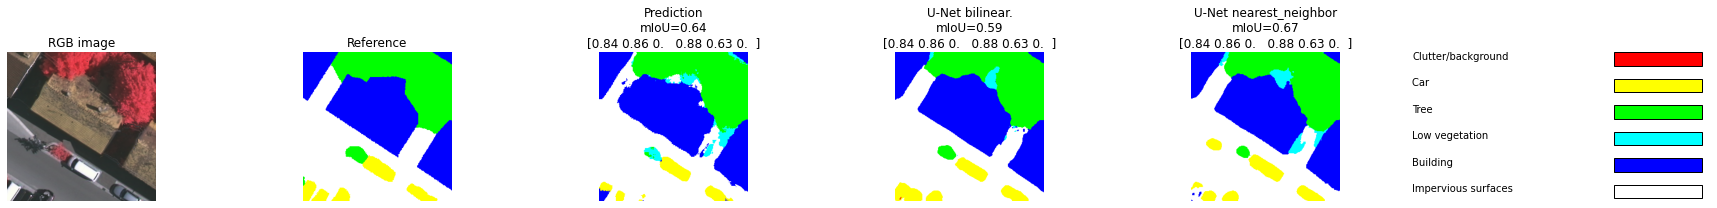

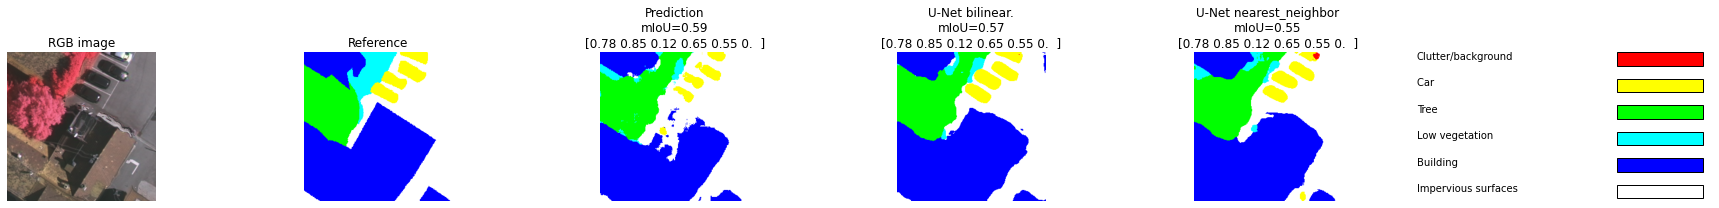

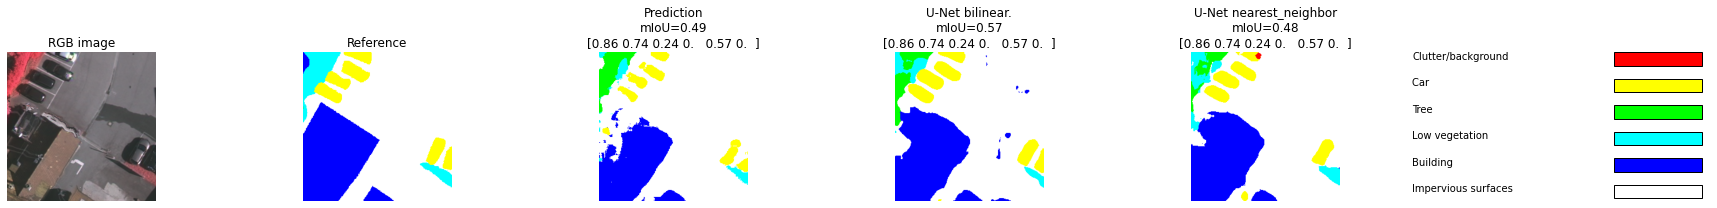

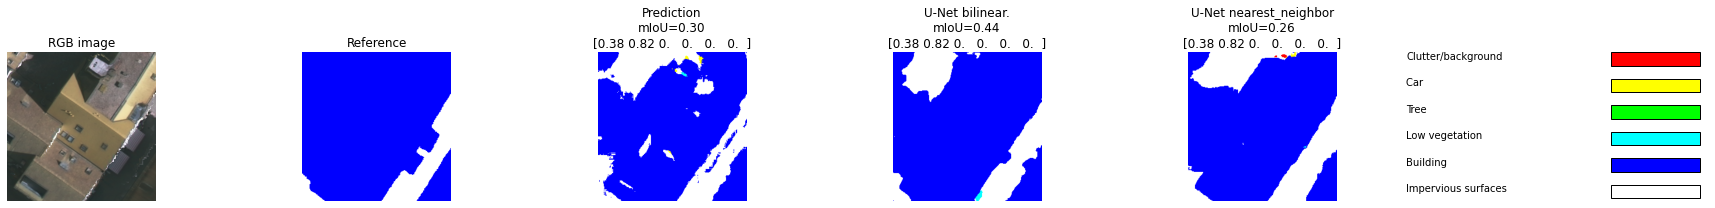

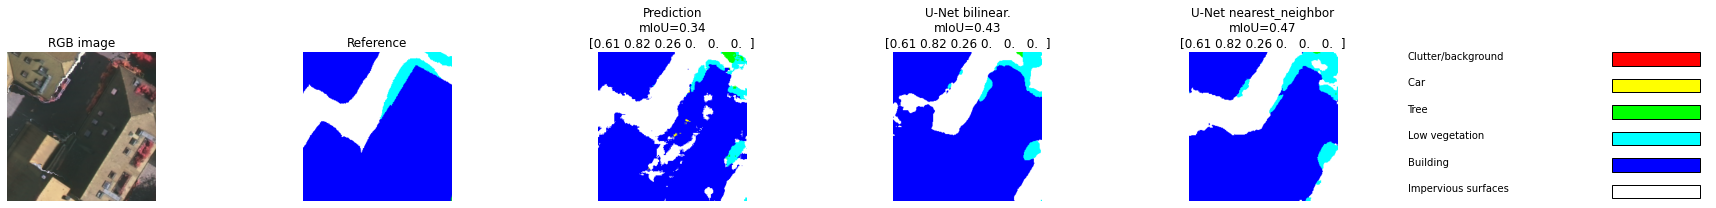

In [30]:
#@title Predictions Visualization { run: "auto"}
#@markdown Select a sample
id_batch = 14 #@param {type:"slider", min:0, max:189, step:1}

# Get a batch from the generator for testing
x,y = data_gen_test.__getitem__(id_batch)
# Obtain the prediction from the trained model
prediction1 = model_unet_transpose_conv.predict(x)
prediction2 = model_unet_bilinear.predict(x)
prediction3 = model_unet_nearest_neighbor.predict(x)
# Iterate over each sample in the batch
for x_i,y_i,p_1,p_2,p_3 in zip(x,y,
                                        prediction1,
                                        prediction2,
                                        prediction3):
                                        
  # For visualization: [0,1] => [0,255]
  x_i = x_i*255
  x_i = x_i.astype(np.uint8)
  # From one hot encoding to integer
  gt = np.argmax(y_i, axis=-1)
  pred1 = np.argmax(p_1, axis=-1)
  pred2 = np.argmax(p_2, axis=-1)
  pred3 = np.argmax(p_3, axis=-1)
  # Object to compute the mean IoU
  m_iou = OneHotMeanIoU(num_classes=n_classes)
  m_iou.update_state(y_true=y_i, 
                     y_pred=p_1)
  m_iou2 = OneHotMeanIoU(num_classes=n_classes)
  m_iou2.update_state(y_true=y_i, 
                     y_pred=p_2)
  m_iou3 = OneHotMeanIoU(num_classes=n_classes)
  m_iou3.update_state(y_true=y_i, 
                     y_pred=p_3)
  # List to storage IoU per class
  iou_all1 = []
  iou_all2 = []
  iou_all3 = []
  for id_class in range(n_classes):
    # Object to compute the IoU for each class
    m_iou_class = OneHotIoU(num_classes=n_classes, 
                            target_class_ids=[id_class])
    m_iou_class.update_state(y_true=y_i, 
                             y_pred=p_1)
    m_iou_class2 = OneHotIoU(num_classes=n_classes, 
                            target_class_ids=[id_class])
    m_iou_class2.update_state(y_true=y_i, 
                             y_pred=p_2)
    m_iou_class3 = OneHotIoU(num_classes=n_classes, 
                            target_class_ids=[id_class])
    m_iou_class3.update_state(y_true=y_i, 
                             y_pred=p_3)
    # Save IoU for each class
    iou_all1.append(m_iou_class.result().numpy())
    iou_all2.append(m_iou_class.result().numpy())
    iou_all3.append(m_iou_class.result().numpy())
  # Colo images for the Ground Truth and Prediction
  gt_rgb = np.zeros((gt.shape[0],gt.shape[1],3), dtype=np.uint8)
  pred1_rgb = np.zeros((gt.shape[0],gt.shape[1],3), dtype=np.uint8)
  pred2_rgb = np.zeros((gt.shape[0],gt.shape[1],3), dtype=np.uint8)
  pred3_rgb = np.zeros((gt.shape[0],gt.shape[1],3), dtype=np.uint8)
  # Assign a color to each integer value from the given dictionary
  for key,value in color2index.items():
    gt_rgb[gt==value] = key
    pred1_rgb[pred1==value] = key
    pred2_rgb[pred2==value] = key
    pred3_rgb[pred3==value] = key
  # Visualization
  plt.figure(figsize=(25,3))
  plt.subplot(1,6,1)
  plt.imshow(x_i)
  plt.title("RGB image")
  plt.axis("off")

  # Ground Truth
  plt.subplot(1,6,2)
  plt.imshow(gt_rgb)
  plt.title("Reference")
  plt.axis("off")

  # Prediction U-Net conv
  plt.subplot(1,6,3)
  plt.imshow(pred1_rgb)
  plt.title("Prediction\nmIoU={:.2f}\n{}".format(m_iou.result().numpy(),np.round(iou_all1, decimals=2)))
  plt.axis("off")
  # Prediction U-Net bilinear
  plt.subplot(1,6,4)
  plt.imshow(pred2_rgb)
  plt.title("U-Net bilinear.\nmIoU={:.2f}\n{}".format(m_iou2.result().numpy(),np.round(iou_all2, decimals=2)))
  plt.axis("off")
  # Prediction U-Net nearest_neighbor
  plt.subplot(1,6,5)
  plt.imshow(pred3_rgb)
  plt.title("U-Net nearest_neighbor\nmIoU={:.2f}\n{}".format(m_iou3.result().numpy(),np.round(iou_all3, decimals=2)))

  plt.axis("off")
  # Colormap
  g = plt.subplot(1,6,6)
  g.axes.set_xlim(0,3.4)
  g.axes.set_ylim(-0.01,0.55)

  g.text(0, 0.025, "Impervious surfaces")
  g.text(0, 0.125, "Building ")
  g.text(0, 0.225, "Low vegetation")
  g.text(0, 0.325, "Tree ")
  g.text(0, 0.425, "Car ")
  g.text(0, 0.525, "Clutter/background")

  x_rec = 2.3
  g.add_patch(patches.Rectangle((x_rec,0.0), 1, 0.05, facecolor="#FFFFFF", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.1), 1, 0.05, facecolor="#0000FF", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.2), 1, 0.05, facecolor="#00FFFF", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.3), 1, 0.05, facecolor="#00FF00", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.4), 1, 0.05, facecolor="#FFFF00", edgecolor="black"))
  g.add_patch(patches.Rectangle((x_rec,0.5), 1, 0.05, facecolor="#FF0000", edgecolor="black"))
  g.axis("off")

  plt.tight_layout()

  plt.show()